# Search: Solving a Maze Using a Goal-based Agent

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file. 


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root node to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [4]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [5]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))
mh.find_pos(maze)

Position(0,0): X
Position(8,1): G


(3, 11)

A helper function to visualize the maze is also available.

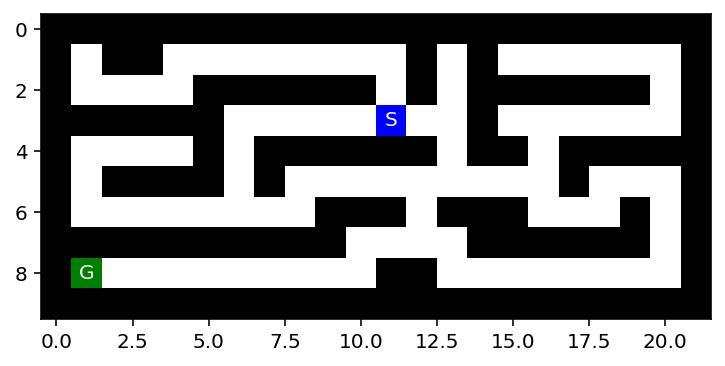

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [39]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))
print(maze)
mh.look(maze, (1,5))

Start location: (3, 11)
Goal location: (8, 1)
[['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' ' ' 'S' ' ' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' 'X' ' ' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' 'X' 'X' ' ' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X'
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' 'X' ' ' 'X' 'X' 'X' ' ' ' '
  ' ' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']]


' '

Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /home/jovyan/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [70]:
class Node:
    def __init__(self, pos, parent, action, cost, h_val = None):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.h_val = h_val

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}; h_val = {self.h_val};"
    # needed so the priority queue works in Node Object
    # def __lt__(self, other):
    #     selfPriority = (self.cost, self.hval)
    #     otherPriority = (other.cost, self.hval)
    #     return selfPriority < otherPriority

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../Python_Code_Examples/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

#### Answer
- initial state = the starting position, S, in the maze
- actions = the different ways an agent can change states so in this case moving to an adjacent position in the maze
- transition model = 
- Goal state = is reaching the end of the maze or the G
- Path cost = every time you move to a new position it costs 1

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [8]:
# Your answer goes here


## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [29]:
# Your code goes here
import collections
def BFS(problem):
    node = Node(mh.find_pos(problem), None, 'None', 0)
    goal = Node(mh.find_pos(problem, 'G'), None, 'None', 0)
    frontier = collections.deque([node])
    if(node.pos == goal.pos): return node
    reached = {node}
    while frontier.__len__() > 0:
        node = frontier.popleft()
        for child in expand(problem, node):
            s = child.pos
            if(s == goal.pos): return child
            if(s not in reached):
                reached.add(s)
                frontier.append(child)
    return "mission failed you'll get'em next time"


In [98]:
def is_cycle(path, position):
    for child in path:
        if (child.pos == position): return True
    return False
def DFS(problem):
    node = Node(mh.find_pos(problem), None, 'None', 0)
    goal = Node(mh.find_pos(problem, 'G'), None, 'None', 0)
    frontier = collections.deque([node])
    result = 'failure'
    while frontier.__len__() > 0:
        node = frontier.popleft()
        if(node.pos == goal.pos): return node
        if(node.parent == None): 
            for child in expand(problem, node):
                frontier.appendleft(child)
            continue
        path = node.parent.get_path_from_root()
        check = is_cycle(path, node.pos)
        if check: 
            print('deadend', node.pos)
            node = frontier.popleft()
        if not check:
            for child in expand(problem, node):
                frontier.appendleft(child)
    return result
ween = DFS(maze)

deadend (3, 12)
deadend (3, 13)
deadend (3, 10)
deadend (1, 11)
deadend (2, 11)


IndexError: pop from an empty deque

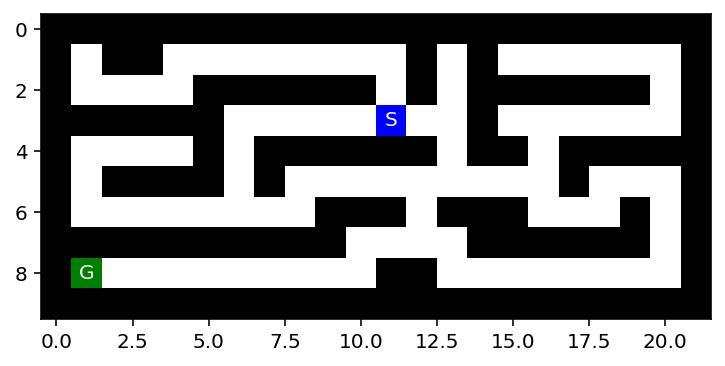

In [64]:
mh.show_maze(maze)

In [4]:
def expand(problem, node):
    actions = []
    s = node.pos
    down  = (s[0]+1,s[1])
    up    = (s[0]-1,s[1])
    left  = (s[0],s[1]-1)
    right = (s[0], s[1]+1)
    if(mh.look(problem, up) == 'G'):
        actions.append(Node(up, node, 'finshed', node.cost+1))
    if(mh.look(problem, up) == ' '):
        temp = Node(up, node, 'up', node.cost+1)
        actions.append(temp)
    if(mh.look(problem, down) == 'G'):
        actions.append(Node(down, node, 'finshed', node.cost+1))
    if(mh.look(problem, down) == ' '):
        temp = Node(down, node, 'down', node.cost+1)
        actions.append(temp)
    if(mh.look(problem, left) == 'G'):
        actions.append(Node(left, node, 'finshed', node.cost+1))
    if(mh.look(problem, left) == ' '):
        temp = Node(left, node, 'left', node.cost+1)
        actions.append(temp)
    if(mh.look(problem, right) == 'G'):
        actions.append(Node(right, node, 'finshed', node.cost+1))
    if(mh.look(problem, right) == ' '):
        temp = Node(right, node, 'right', node.cost+1)
        actions.append(temp)
    return actions

In [138]:
path = BFS(maze)
print(path.__str__())
x= path.get_path_from_root()
print(x[len(x)-1])
print(len(x))
for i in x:
    print(i.pos)

Node - pos = (8, 1); action = finshed; cost = 19
Node - pos = (8, 1); action = finshed; cost = 19
20
(3, 11)
(3, 12)
(3, 13)
(4, 13)
(5, 13)
(5, 12)
(6, 12)
(7, 12)
(7, 11)
(7, 10)
(8, 10)
(8, 9)
(8, 8)
(8, 7)
(8, 6)
(8, 5)
(8, 4)
(8, 3)
(8, 2)
(8, 1)


In [79]:
node = Node(mh.find_pos(maze), None, 'None', 0)
goal = Node(mh.find_pos(maze, 'G'), None, 'None', 0)
lifo = collections.deque()
nodes = expand(maze, node)
for child in nodes:
    lifo.appendleft(child)
for i in lifo:
    print(i.pos)
test = lifo.popleft()
if test in lifo: print(True)
else: print(False)

(3, 12)
(3, 10)
(2, 11)
False


In [ ]:
def DFS(problem):
    node = Node(mh.find_pos(problem), None, 'None', 0)
    goal = mh.find_pos(problem, 'G')
    frontier = collections.deque([node]) #created lifo queue and inserted initial node
    result = 'failure'
    while not frontier:
        node = frontier.popleft()
        if(node.pos == goal): return node
        

How does BFS and DFS deal with loops (cycles)?

In [10]:
# Discussion

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [11]:
# Discussion

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

In [77]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)

Node - pos = (3, 11); action = None; cost = 0; h_val = 0;
Node - pos = (3, 10); action = east; cost = 1; h_val = 14;
Node - pos = (3, 9); action = east; cost = 2; h_val = 13;
Node - pos = (3, 8); action = east; cost = 3; h_val = 12;
Node - pos = (3, 7); action = east; cost = 4; h_val = 11;
Node - pos = (3, 6); action = east; cost = 5; h_val = 10;
Node - pos = (4, 6); action = south; cost = 6; h_val = 9;
Node - pos = (5, 6); action = south; cost = 7; h_val = 8;
Node - pos = (6, 6); action = south; cost = 8; h_val = 7;
Node - pos = (6, 5); action = east; cost = 9; h_val = 6;
Node - pos = (6, 4); action = east; cost = 10; h_val = 5;
Node - pos = (6, 3); action = east; cost = 11; h_val = 4;
Node - pos = (6, 2); action = east; cost = 12; h_val = 3;
Node - pos = (6, 1); action = east; cost = 13; h_val = 2;
Node - pos = (5, 1); action = north; cost = 14; h_val = 3;
Node - pos = (4, 1); action = north; cost = 15; h_val = 4;
Node - pos = (4, 2); action = west; cost = 16; h_val = 5;
Node - pos =

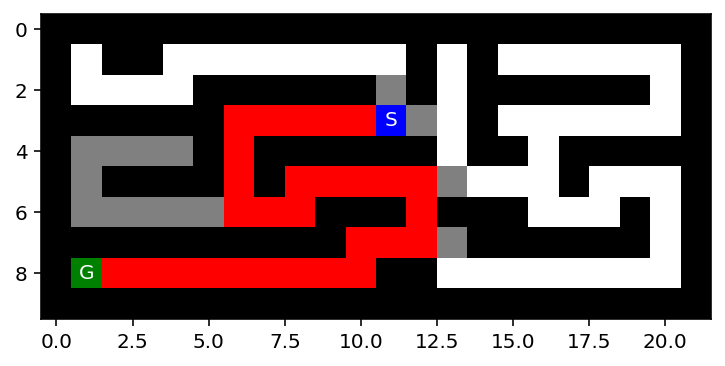

In [76]:
# Your code goes here
def greedyBFS(problem):
    frontier_size = 0
    tree_size = 0 
    nodes_expanded = 0
    max_frontier = 1
    root = Node(mh.find_pos(problem), None, None, 0, 0)
    goal = mh.find_pos(problem, 'G')
    frontier = []
    frontier.append((root.cost, root))
    frontier_size = frontier_size + 1
    frontier.sort(key=lambda i: i[0])
    reached = {}
    tree_size += 1
    while len(frontier) > 0:
        node = frontier.pop(0)[1]
        frontier_size = frontier_size - 1
        if node.pos == goal: 
            max_depth=0
            cost=0
            child = node
            while child != root:
                max_depth = max_depth + 1
                x=child.pos[0]
                y=child.pos[1]
                if(problem[x, y] != 'G'):
                    problem[x][y]=4
                cost = node.cost #maybe change
                child = child.parent
            print(f'Nodes Expanded '+ str(nodes_expanded))
            print(f'Cost '+ str(cost))
            print(f'Max Frontier '+str(max_frontier))
            print(f'Max Depth '+ str(max_depth))
            print(f'Tree Size '+str(tree_size))
            mh.show_maze(problem)
            return node
        leaves=expandGreedy(problem,node,goal)
        tree_size=tree_size+len(leaves)
        for child in leaves:
            nodes_expanded = nodes_expanded + 1
            s = child[1].pos
            if s not in reached or child[1].cost < reached[s].cost:
                reached[s] = child[1]
                frontier_size += 1
                if problem[s[0],s[1]] == ' ':
                    problem[s[0]][s[1]] = '.'
                frontier.append((child[0],child[1]))
                frontier.sort(key = lambda i: i[0])
            if frontier_size > max_frontier:
                max_frontier = frontier_size
    return 'failed'
ween = greedyBFS(maze)

Node - pos = (3, 11); action = None; cost = 0; h_val = 0;
Node - pos = (3, 10); action = east; cost = 1; h_val = 15;
Node - pos = (3, 9); action = east; cost = 2; h_val = 15;
Node - pos = (3, 8); action = east; cost = 3; h_val = 15;
Node - pos = (3, 7); action = east; cost = 4; h_val = 15;
Node - pos = (3, 6); action = east; cost = 5; h_val = 15;
Node - pos = (4, 6); action = south; cost = 6; h_val = 15;
Node - pos = (5, 6); action = south; cost = 7; h_val = 15;
Node - pos = (6, 6); action = south; cost = 8; h_val = 15;
Node - pos = (6, 5); action = east; cost = 9; h_val = 15;
Node - pos = (6, 4); action = east; cost = 10; h_val = 15;
Node - pos = (6, 3); action = east; cost = 11; h_val = 15;
Node - pos = (6, 2); action = east; cost = 12; h_val = 15;
Node - pos = (6, 1); action = east; cost = 13; h_val = 15;
Node - pos = (2, 11); action = north; cost = 1; h_val = 17;
Node - pos = (3, 12); action = west; cost = 1; h_val = 17;
Node - pos = (3, 11); action = west; cost = 2; h_val = 17;
No

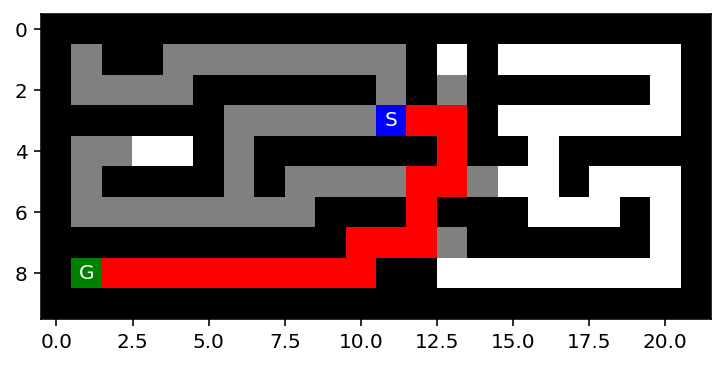

In [78]:
# Your code goes here
def aStar(problem):
    frontier_size = 0
    tree_size = 0 
    nodes_expanded = 0
    max_frontier = 1
    root = Node(mh.find_pos(problem), None, None, 0, 0)
    goal = mh.find_pos(problem, 'G')
    frontier = []
    frontier.append((root.cost, root))
    frontier_size = frontier_size + 1
    frontier.sort(key=lambda i: i[0])
    reached = {}
    tree_size += 1
    while len(frontier) > 0:
        node = frontier.pop(0)[1]
        frontier_size = frontier_size - 1
        if node.pos == goal: 
            max_depth=0
            cost=0
            child = node
            while child != root:
                max_depth = max_depth + 1
                x=child.pos[0]
                y=child.pos[1]
                if(problem[x, y] != 'G'):
                    problem[x][y]=4
                cost = node.cost #maybe change
                child = child.parent
            print(f'Nodes Expanded '+ str(nodes_expanded))
            print(f'Cost '+ str(cost))
            print(f'Max Frontier '+str(max_frontier))
            print(f'Max Depth '+ str(max_depth))
            print(f'Tree Size '+str(tree_size))
            mh.show_maze(problem)
            return node
        leaves=expandStar(problem,node,goal)
        tree_size=tree_size+len(leaves)
        for child in leaves:
            nodes_expanded = nodes_expanded + 1
            s = child[1].pos
            if s not in reached or child[1].cost < reached[s].cost:
                reached[s] = child[1]
                frontier_size += 1
                if problem[s[0],s[1]] == ' ':
                    problem[s[0]][s[1]] = '.'
                frontier.append((child[0],child[1]))
                frontier.sort(key = lambda i: i[0])
            if frontier_size > max_frontier:
                max_frontier = frontier_size
    return 'failed'
x = aStar(maze)

In [32]:
def expandGreedy(problem, node, goal):
    moves=[]
    north=problem[int(node.pos[0]-1)][int(node.pos[1])]
    if north!='X':
        N=Node((int(node.pos[0]-1),int(node.pos[1])),node, 'north', node.cost+1, 
        get_manhattan_distance(node,(int(node.pos[0]-1)),int(node.pos[1]),goal))
        moves.append((N.h_val,N))
    south=problem[int(node.pos[0]+1)][int(node.pos[1])]
    if south!='X':
        S=Node((int(node.pos[0]+1),int(node.pos[1])),node, 'south', node.cost+1,
        get_manhattan_distance(node,(int(node.pos[0]+1)),int(node.pos[1]), goal))
        moves.append((S.h_val,S))
    east=problem[int(node.pos[0])][int(node.pos[1]-1)]
    if east!='X':
        E=Node((int(node.pos[0]),int(node.pos[1]-1)),node, 'east', node.cost+1,
        get_manhattan_distance(node,(int(node.pos[0])),int(node.pos[1]-1), goal))
        moves.append((E.h_val,E))
    west=problem[int(node.pos[0])][int(node.pos[1]+1)]
    if west!='X':
        W=Node((int(node.pos[0]),int(node.pos[1]+1)),node,'west', node.cost+1,
        get_manhattan_distance(node,(int(node.pos[0])),int(node.pos[1]+1), goal))
        moves.append((W.h_val,W))
    moves.sort(key = lambda i: i[0])
    return moves
def expandStar(problem, node, goal):
    moves=[]
    north=problem[int(node.pos[0]-1)][int(node.pos[1])]
    if north!='X':
        N=Node((int(node.pos[0]-1),int(node.pos[1])),node, 'north', node.cost+1, 
        get_manhattan_distance(node,(int(node.pos[0]-1)),int(node.pos[1]),goal) + node.cost+1)
        moves.append((N.h_val,N))
    south=problem[int(node.pos[0]+1)][int(node.pos[1])]
    if south!='X':
        S=Node((int(node.pos[0]+1),int(node.pos[1])),node, 'south', node.cost+1,
        get_manhattan_distance(node,(int(node.pos[0]+1)),int(node.pos[1]), goal) + node.cost+1)
        moves.append((S.h_val,S))
    east=problem[int(node.pos[0])][int(node.pos[1]-1)]
    if east!='X':
        E=Node((int(node.pos[0]),int(node.pos[1]-1)),node, 'east', node.cost+1,
        get_manhattan_distance(node,(int(node.pos[0])),int(node.pos[1]-1), goal) + node.cost+1)
        moves.append((E.h_val,E))
    west=problem[int(node.pos[0])][int(node.pos[1]+1)]
    if west!='X':
        W=Node((int(node.pos[0]),int(node.pos[1]+1)),node,'west', node.cost+1,
        get_manhattan_distance(node,(int(node.pos[0])),int(node.pos[1]+1), goal) + node.cost+1)
        moves.append((W.h_val,W))
    moves.sort(key = lambda i: i[0])
    return moves
def get_manhattan_distance(node, x, y, goal):
    """ 
    Return the manhattan distance between points p and q
    assuming both to have the same number of dimensions
    """
    # cost=abs((node.pos[0]-x)+(node.pos[1]-y))
    man_cost=abs(goal[0]-x)+ abs(goal[1]-y)
    return man_cost

In [66]:
y= x.get_path_from_root()
for i in y:
    print(i.pos)

(3, 11)
(3, 12)
(3, 13)
(4, 13)
(5, 13)
(5, 12)
(6, 12)
(7, 12)
(7, 11)
(7, 10)
(8, 10)
(8, 9)
(8, 8)
(8, 7)
(8, 6)
(8, 5)
(8, 4)
(8, 3)
(8, 2)
(8, 1)


In [197]:
print(x.__str__())
path = x.get_path_from_root()
for i in path: print(i.__str__())

Node - pos = (8, 1); action = finshed; cost = 19
Node - pos = (3, 11); action = None; cost = 0
Node - pos = (3, 12); action = right; cost = 1
Node - pos = (3, 13); action = right; cost = 2
Node - pos = (4, 13); action = down; cost = 3
Node - pos = (5, 13); action = down; cost = 4
Node - pos = (5, 12); action = left; cost = 5
Node - pos = (6, 12); action = down; cost = 6
Node - pos = (7, 12); action = down; cost = 7
Node - pos = (7, 11); action = left; cost = 8
Node - pos = (7, 10); action = left; cost = 9
Node - pos = (8, 10); action = down; cost = 10
Node - pos = (8, 9); action = left; cost = 11
Node - pos = (8, 8); action = left; cost = 12
Node - pos = (8, 7); action = left; cost = 13
Node - pos = (8, 6); action = left; cost = 14
Node - pos = (8, 5); action = left; cost = 15
Node - pos = (8, 4); action = left; cost = 16
Node - pos = (8, 3); action = left; cost = 17
Node - pos = (8, 2); action = left; cost = 18
Node - pos = (8, 1); action = finshed; cost = 19


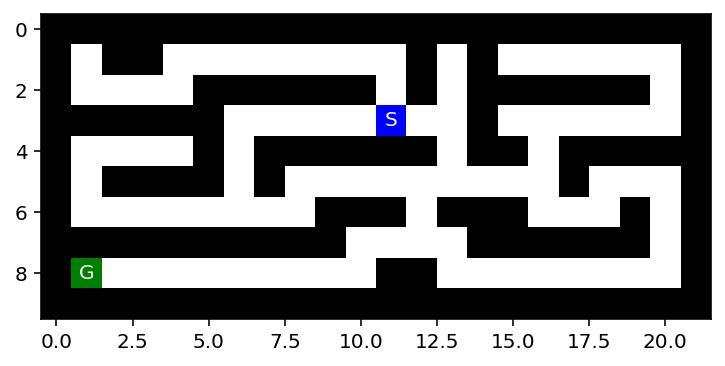

'G'

In [253]:
mh.show_maze(maze)
maze[8,1]

In [216]:

frontier = PriorityQueue()
node = Node(mh.find_pos(maze), None, 'None', 0)
goal = Node(mh.find_pos(maze, 'G'), None, 'None', 9)
# frontier.put(node)
# frontier.put(goal)
frontier.put((node.cost, node))
frontier.put((goal.cost, goal))
frontier.get()
ween = frontier.get()[1]
ween.__str__()
# frontier.get().pos

'Node - pos = (8, 1); action = None; cost = 9'

Are your implementations complete and optimal? What is the time and space complexity?

In [13]:
# Discussion

## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [14]:
# Add code

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../Python_Code_Examples/charts_and_tables.ipynb)). 

In [15]:
# Add charts

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [16]:
# Add discussion

## Graduate student advanced task: IDS and Multiple goals [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement in addition IDS (iterative deepening search using DFS). 

Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [17]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [18]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [19]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [20]:
# Your code/answer goes here